In [21]:
""" THIS IS THE SAME AS VERSION 04. 
The difference is that the guessability here is set to 0.333 (3 options), instead of 0.5 [0.4,0.6] (true/false)

IMPORTANT: these versions do not include questions 2 and 3. They were discarded due to very low performance

"""

' THIS IS THE SAME AS VERSION 04. \nThe difference is that the guessability here is set to 0.333 (3 options), instead of 0.5 [0.4,0.6] (true/false)\n'

In [2]:
import pandas as pd

# Load the data
file_path = 'DiagnosticResults_19q.csv'
data = pd.read_csv(file_path, index_col=0)

# Drop the first column (subject labels) from the data
# data = data.drop(columns=data.columns[0])


# Example: Define theta as the mean response across items
data.head()

Q1  Q4  Q5  Q6  Q7  Q8  Q9  Q10  Q11  Q12  Q13  Q14  Q15  Q16  Q17  \
SUBJECT                                                                       
S1        1   1   0   0   0   1   1    1    0    0    1    1    1    1    0   
S2        1   1   0   1   0   1   0    0    0    1    0    0    0    0    0   
S3        1   1   0   1   1   1   0    0    0    0    1    1    0    1    0   
S4        1   1   0   1   0   1   0    0    0    0    1    0    1    1    0   
S7        1   1   0   1   0   1   0    0    0    1    1    0    1    0    0   

         Q18  Q19  Q20  Q21  
SUBJECT                      
S1         0    1    1    1  
S2         0    0    1    1  
S3         1    0    0    0  
S4         0    1    0    0  
S7         0    0    0    1

In [3]:
# Define ability estimates (theta) for each student as initial guess (e.g., average score)
theta = data.mean(axis=1).values

# Assume binary response for simplicity (1 = correct, 0 = incorrect)
responses = data.values  # Convert DataFrame to numpy array for easier manipulation
print(theta)

[0.63157895 0.36842105 0.47368421 0.42105263 0.42105263 0.63157895
 0.42105263 0.42105263 0.36842105 0.52631579 0.47368421 0.36842105
 0.31578947 0.47368421 0.52631579 0.42105263 0.47368421 0.52631579
 0.52631579 0.47368421 0.52631579 0.36842105 0.42105263 0.36842105
 0.31578947 0.26315789 0.42105263 0.47368421 0.36842105 0.42105263
 0.57894737 0.36842105 0.52631579 0.73684211 0.42105263 0.21052632
 0.52631579 0.36842105 0.52631579 0.52631579 0.42105263 0.47368421
 0.47368421 0.73684211 0.36842105 0.52631579 0.52631579 0.47368421
 0.47368421 0.57894737 0.63157895 0.52631579 0.52631579 0.36842105
 0.42105263 0.47368421 0.47368421 0.42105263 0.31578947 0.42105263
 0.68421053 0.57894737 0.47368421 0.47368421 0.42105263 0.47368421
 0.42105263 0.42105263 0.47368421 0.47368421 0.57894737 0.68421053
 0.52631579 0.52631579 0.42105263 0.42105263 0.26315789 0.57894737
 0.47368421 0.36842105]


In [4]:
import numpy as np
from scipy.optimize import minimize

def three_pl_model(theta, a, b, c):
    return c + (1 - c) / (1 + np.exp(-a * (theta - b)))


In [25]:
def log_likelihood(params, *args):
    theta, responses = args
    a, b, c = params
    prob = three_pl_model(theta, a, b, c)
    
    # Avoid log(0) by clipping probabilities
    prob = np.clip(prob, 1e-6, 1 - 1e-6)
    
    # Regularization to penalize large a (high discrimination)
    penalty = 0.1 * (a - 1)**2  # Penalize deviation of a from 1
    
    return -np.sum(responses * np.log(prob) + (1 - responses) * np.log(1 - prob)) + penalty


# Store the estimated parameters
item_parameters = []

for i in range(responses.shape[1]):
    initial_params = [1.0, 0.0, 0.25]  # a, b, c
    """Difficulty bounds were set to +-2.8. This was so because setting higher bounds made a difference only in 4 items (2, 3, 5 and 11). 
    The reasonably minimum bound is 2.8 because the the highest easiness below 2.8 was item 14 (2.755) """
    
    # Adding bounds to ensure valid parameter estimates
    bounds = [(0.01, 5),  # a: discrimination should be positive
              (-3, 3),      # b: difficulty can vary widely
              (0.2, 1/3)]  # c: guessing should be between 0 and 1

    # Optimize with bounds
    result = minimize(log_likelihood, initial_params, args=(theta, responses[:, i]), bounds=bounds)
    item_parameters.append(result.x)

# Convert to a DataFrame for easier interpretation
item_params_df = pd.DataFrame(item_parameters, columns=['a', 'b', 'c'])
item_params_df

a         b     c
0   2.105982 -0.375971  0.15
1   1.907501 -0.596879  0.15
2   2.273788  1.781548  0.15
3   3.124102  0.243705  0.15
4   2.840206  0.932303  0.15
5   2.306828  0.254172  0.15
6   2.227095  1.197649  0.15
7   4.892023  0.599083  0.15
8   1.911248  2.238288  0.15
9   1.109934  1.256765  0.15
10  3.131954  0.405392  0.15
11  1.825295  1.811368  0.15
12  2.064153 -0.110364  0.15
13  2.292963  0.648105  0.15
14  2.420848  1.175715  0.15
15  2.032352  1.441385  0.15
16  3.052695  0.869976  0.15
17  5.000000  0.582052  0.15
18  3.904462  0.554403  0.15

In [26]:
theta


array([0.63157895, 0.36842105, 0.47368421, 0.42105263, 0.42105263,
       0.63157895, 0.42105263, 0.42105263, 0.36842105, 0.52631579,
       0.47368421, 0.36842105, 0.31578947, 0.47368421, 0.52631579,
       0.42105263, 0.47368421, 0.52631579, 0.52631579, 0.47368421,
       0.52631579, 0.36842105, 0.42105263, 0.36842105, 0.31578947,
       0.26315789, 0.42105263, 0.47368421, 0.36842105, 0.42105263,
       0.57894737, 0.36842105, 0.52631579, 0.73684211, 0.42105263,
       0.21052632, 0.52631579, 0.36842105, 0.52631579, 0.52631579,
       0.42105263, 0.47368421, 0.47368421, 0.73684211, 0.36842105,
       0.52631579, 0.52631579, 0.47368421, 0.47368421, 0.57894737,
       0.63157895, 0.52631579, 0.52631579, 0.36842105, 0.42105263,
       0.47368421, 0.47368421, 0.42105263, 0.31578947, 0.42105263,
       0.68421053, 0.57894737, 0.47368421, 0.47368421, 0.42105263,
       0.47368421, 0.42105263, 0.42105263, 0.47368421, 0.47368421,
       0.57894737, 0.68421053, 0.52631579, 0.52631579, 0.42105

In [27]:
item_parameters

[array([ 2.10598173, -0.37597091,  0.15      ]),
 array([ 1.90750125, -0.5968791 ,  0.15      ]),
 array([2.27378765, 1.78154798, 0.15      ]),
 array([3.12410228, 0.24370533, 0.15      ]),
 array([2.84020614, 0.93230281, 0.15      ]),
 array([2.30682843, 0.25417222, 0.15      ]),
 array([2.22709519, 1.19764909, 0.15      ]),
 array([4.89202344, 0.59908318, 0.15      ]),
 array([1.91124831, 2.23828807, 0.15      ]),
 array([1.1099341 , 1.25676492, 0.15      ]),
 array([3.13195352, 0.40539205, 0.15      ]),
 array([1.82529494, 1.81136779, 0.15      ]),
 array([ 2.06415345, -0.11036418,  0.15      ]),
 array([2.29296345, 0.64810508, 0.15      ]),
 array([2.42084836, 1.17571508, 0.15      ]),
 array([2.0323524 , 1.44138497, 0.15      ]),
 array([3.05269534, 0.86997552, 0.15      ]),
 array([5.        , 0.58205214, 0.15      ]),
 array([3.90446243, 0.55440308, 0.15      ])]

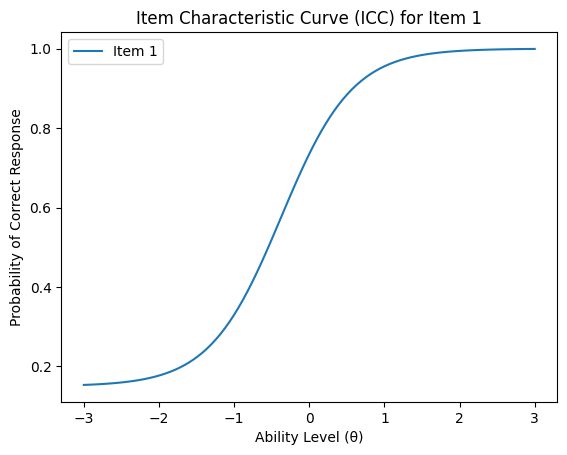

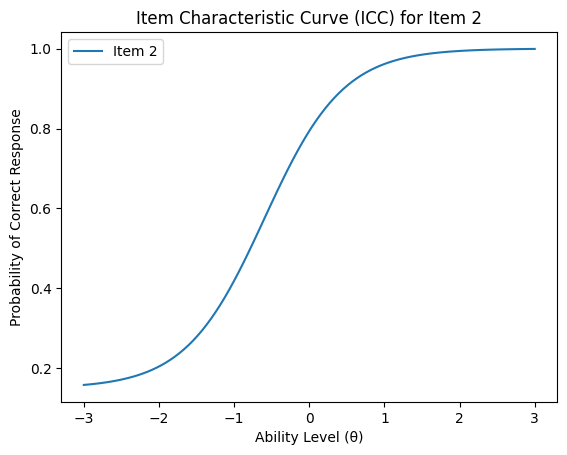

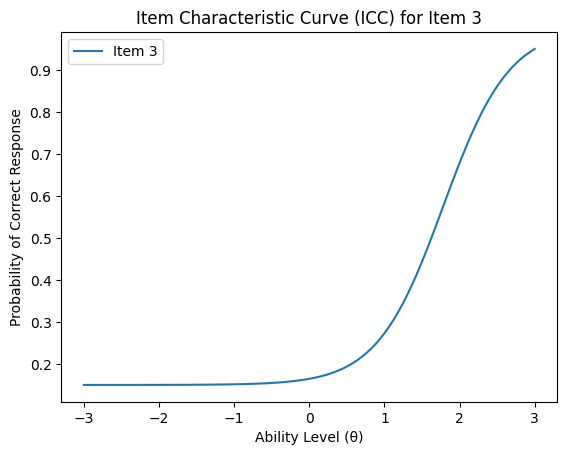

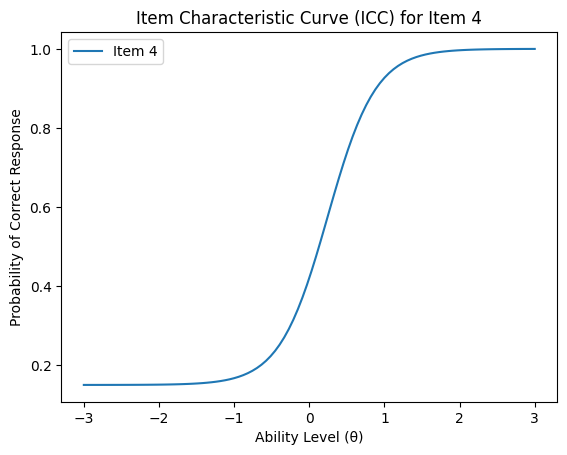

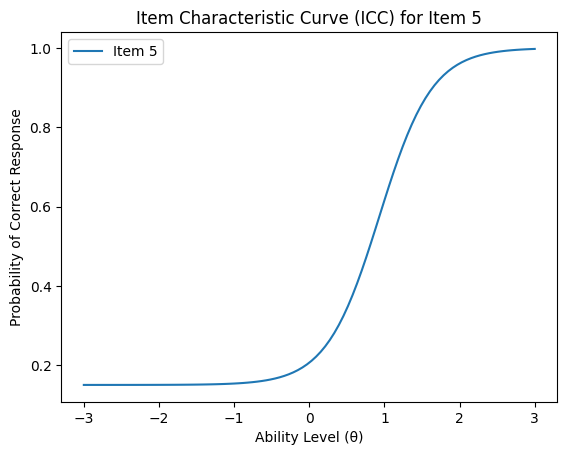

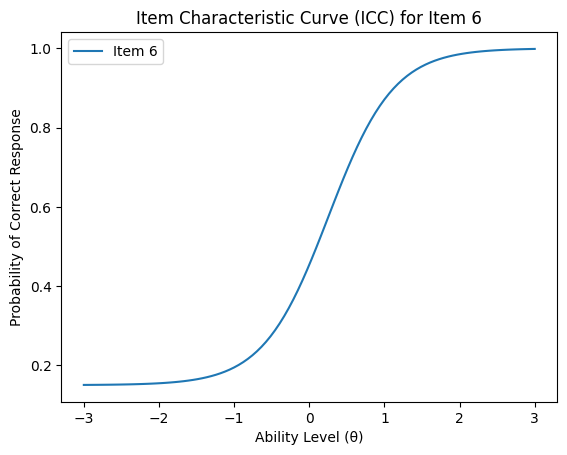

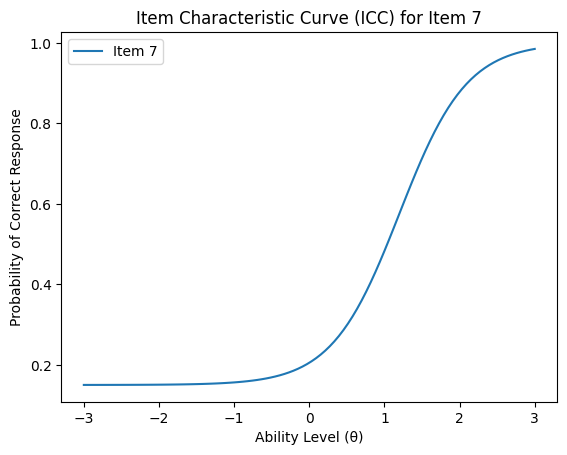

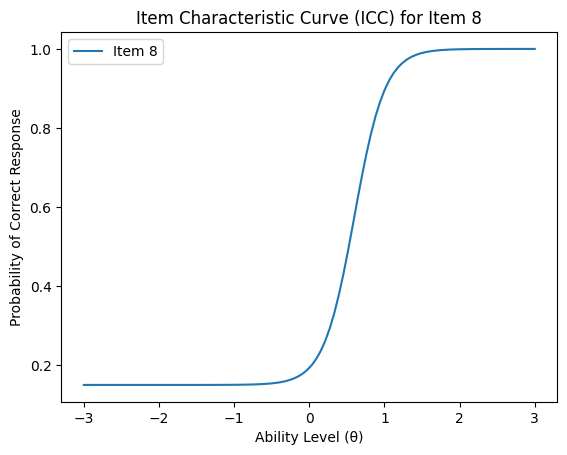

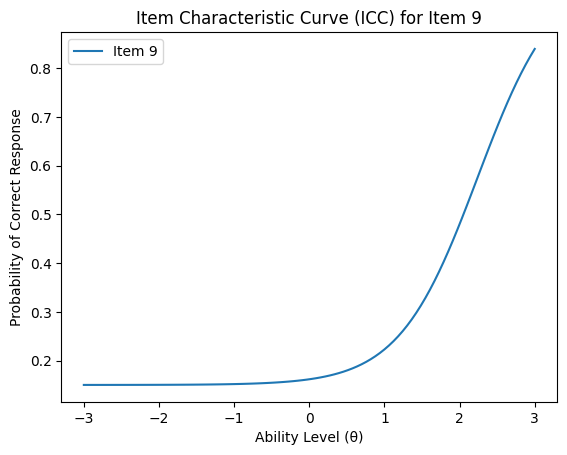

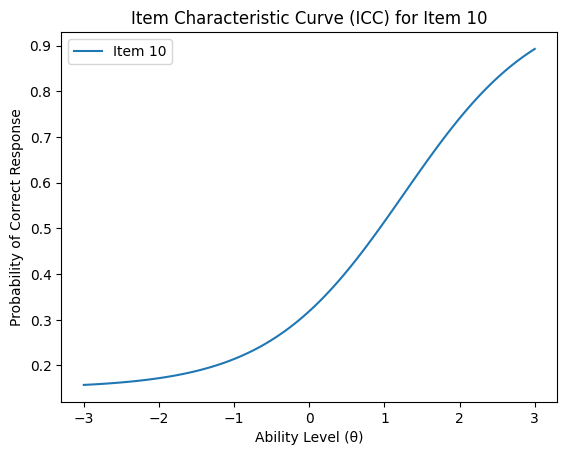

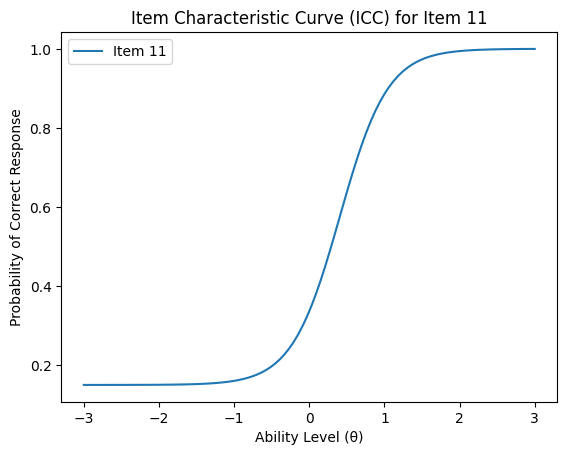

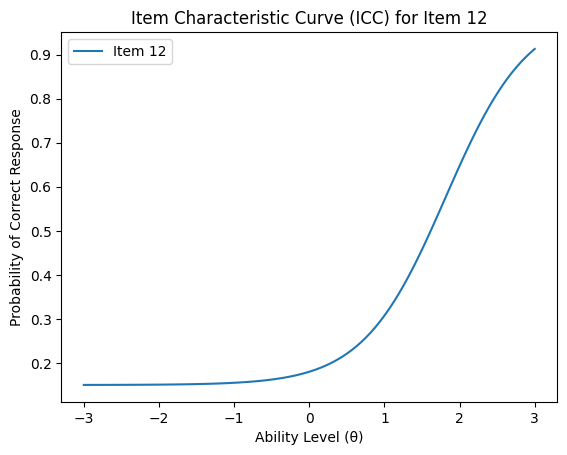

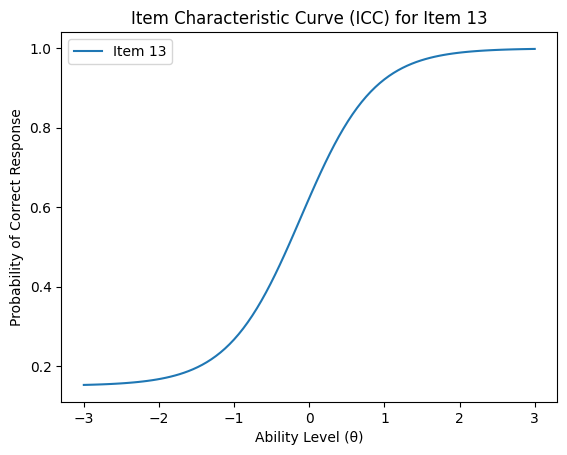

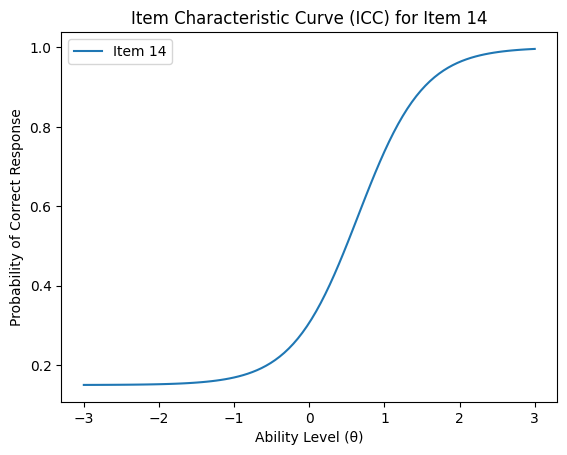

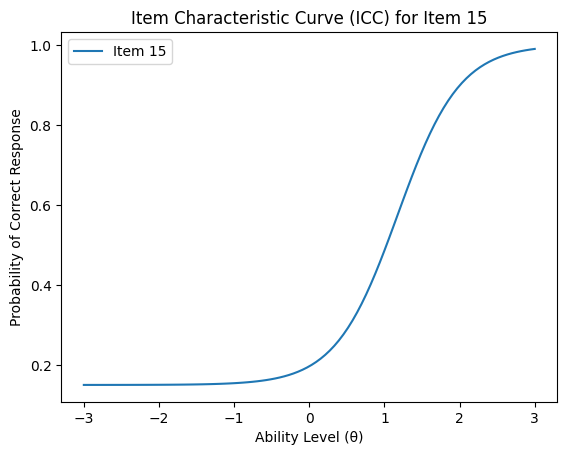

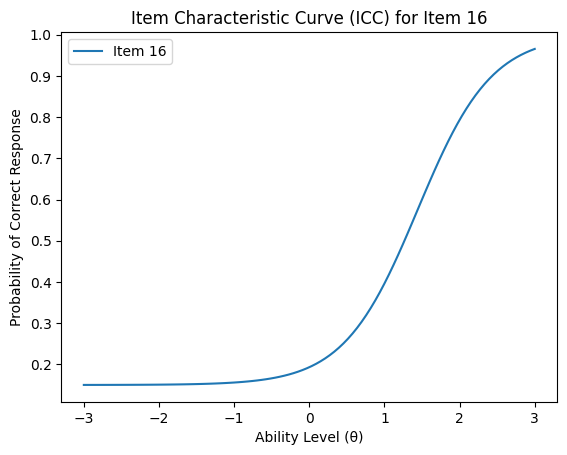

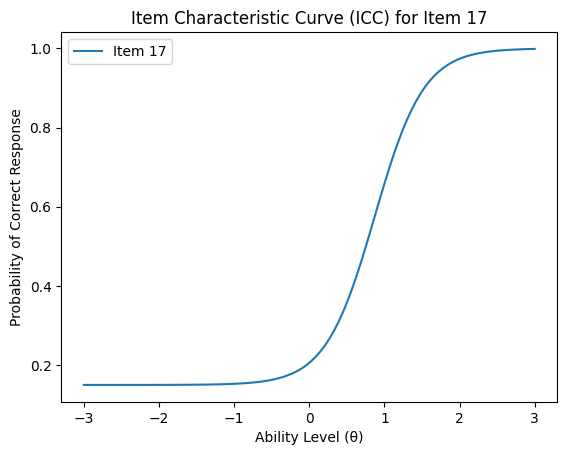

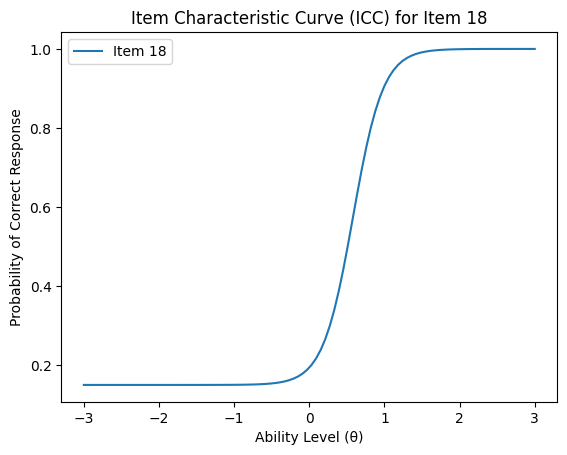

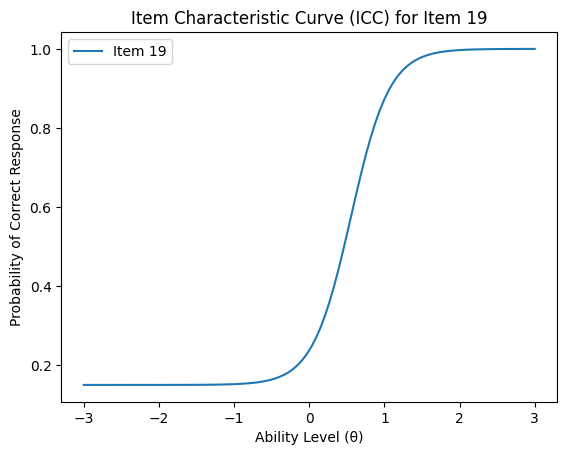

In [28]:
import matplotlib.pyplot as plt

theta_plot = np.linspace(-3, 3, 100)

# Use this theta_plot in the plotting code
for i, params in enumerate(item_parameters):
    a, b, c = params
    predicted_probabilities = three_pl_model(theta_plot, a, b, c)
    
    plt.plot(theta_plot, predicted_probabilities, label=f'Item {i+1}')
    plt.xlabel('Ability Level (θ)')
    plt.ylabel('Probability of Correct Response')
    plt.title(f'Item Characteristic Curve (ICC) for Item {i+1}')
    plt.legend()
    plt.show()


--------------- estimating ability----------------
[1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1]
[array([ 2.10598173, -0.37597091,  0.15      ]), array([ 1.90750125, -0.5968791 ,  0.15      ]), array([2.27378765, 1.78154798, 0.15      ]), array([3.12410228, 0.24370533, 0.15      ]), array([2.84020614, 0.93230281, 0.15      ]), array([2.30682843, 0.25417222, 0.15      ]), array([2.22709519, 1.19764909, 0.15      ]), array([4.89202344, 0.59908318, 0.15      ]), array([1.91124831, 2.23828807, 0.15      ]), array([1.1099341 , 1.25676492, 0.15      ]), array([3.13195352, 0.40539205, 0.15      ]), array([1.82529494, 1.81136779, 0.15      ]), array([ 2.06415345, -0.11036418,  0.15      ]), array([2.29296345, 0.64810508, 0.15      ]), array([2.42084836, 1.17571508, 0.15      ]), array([2.0323524 , 1.44138497, 0.15      ]), array([3.05269534, 0.86997552, 0.15      ]), array([5.        , 0.58205214, 0.15      ]), array([3.90446243, 0.55440308, 0.15      ])]
1 2.105981732430103 -0.37597090515800996 0.1

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 1]
[array([ 2.10598173, -0.37597091,  0.15      ]), array([ 1.90750125, -0.5968791 ,  0.15      ]), array([2.27378765, 1.78154798, 0.15      ]), array([3.12410228, 0.24370533, 0.15      ]), array([2.84020614, 0.93230281, 0.15      ]), array([2.30682843, 0.25417222, 0.15      ]), array([2.22709519, 1.19764909, 0.15      ]), array([4.89202344, 0.59908318, 0.15      ]), array([1.91124831, 2.23828807, 0.15      ]), array([1.1099341 , 1.25676492, 0.15      ]), array([3.13195352, 0.40539205, 0.15      ]), array([1.82529494, 1.81136779, 0.15      ]), array([ 2.06415345, -0.11036418,  0.15      ]), array([2.29296345, 0.64810508, 0.15      ]), array([2.42084836, 1.17571508, 0.15      ]), array([2.0323524 , 1.44138497, 0.15      ]), array([3.05269534, 0.86997552, 0.15      ]), array([5.        , 0.58205214, 0.15      ]), array([3.90446243, 0.55440308, 0.15      ])]
0 2.105981732430103 -0.37597090515800996 0.15 0.734982826015592 -1.5478604052386895 0.863893903

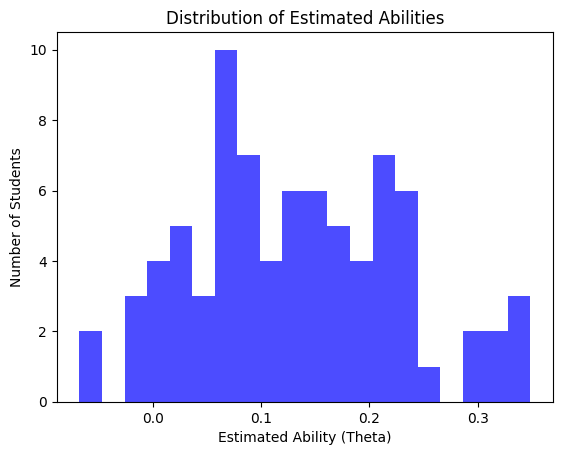

In [29]:
import numpy as np

# Function to compute the probability of a correct response given student's ability (theta)
def probability_correct(theta, a, b, c):
    """Calculate the probability of a correct response given ability (theta), discrimination (a), difficulty (b), and guessing (c)."""
    # Ensure stability by clamping the exponent within reasonable bounds
    exponent = np.clip(-a * (theta - b), -10, 10)
    return c + (1 - c) / (1 + np.exp(exponent))

# Function to estimate the ability (theta) using Maximum Likelihood Estimation (MLE)
def estimate_ability(response_vector, item_parameters, max_iterations=100, learning_rate=0.005, tolerance=1e-6):
    """Estimate the ability of a student using their response pattern and item parameters."""
    print("--------------- estimating ability----------------")
    
    print(response_vector)
    print(item_parameters)
    
    theta = 0  # Start with an initial guess of ability
    i=0
    for _ in range(max_iterations):
        gradient = 0
        hessian = 0
        
        # Calculate gradient and hessian for each item response
        for response, (a, b, c) in zip(response_vector, item_parameters):
            p_correct = probability_correct(theta, a, b, c)
            gradient += (response - p_correct) * (a)
            hessian += a * a * p_correct * (1 - p_correct)
            print(response, a, b, c, p_correct, gradient, hessian)
        
        # Update theta using gradient descent
        if abs(hessian) < tolerance:  # Prevent division by zero
            break
        theta_update = gradient / hessian
        # Clamp theta within a reasonable range to avoid divergence
        theta = np.clip(theta + learning_rate * theta_update, -5, 5)
        
        # Check for convergence
        if abs(theta_update) < tolerance:
            break
    print("theta:", theta)
    return theta

# Estimating abilities for each student using the updated approach
student_abilities = [estimate_ability(student_responses, item_parameters) for student_responses in responses]
print("Estimated Abilities:", student_abilities)

# Plotting the distribution of estimated abilities
import matplotlib.pyplot as plt

plt.hist(student_abilities, bins=20, color='blue', alpha=0.7)
plt.xlabel('Estimated Ability (Theta)')
plt.ylabel('Number of Students')
plt.title('Distribution of Estimated Abilities')
plt.show()


In [30]:
print("Estimated Abilities:", student_abilities)

Estimated Abilities: [np.float64(0.2943453523424083), np.float64(0.06882833033333201), np.float64(0.10198211841219666), np.float64(0.07718440661888772), np.float64(0.07194056191396231), np.float64(0.28934380391377656), np.float64(0.046191663407141946), np.float64(0.08083463171994736), np.float64(0.06483551649136123), np.float64(0.22159592861355246), np.float64(0.14649458675488436), np.float64(0.06745763468609449), np.float64(-0.009720384498493896), np.float64(0.12313913032528555), np.float64(0.2403390576761584), np.float64(0.07382264822206562), np.float64(0.1661201768956699), np.float64(0.20896048550944538), np.float64(0.20611562035419648), np.float64(0.07966459169480113), np.float64(0.23851521016036778), np.float64(0.01854667233442884), np.float64(0.07315602610170623), np.float64(0.0036069622642201852), np.float64(0.0034364290884627445), np.float64(-0.0607681277848909), np.float64(0.0195924480804067), np.float64(0.20545007285459174), np.float64(0.12055299971510534), np.float64(0.09317